In [1]:
# To use cleaning process if needed
from utils import *
from config_file import DOWNLOAD_ROOT, DATASETS_PATH, DOWNLOAD_URL, TWEETS_PATH

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from ggplot import *

import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import string
import unicodedata
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
import re
from pyspark.conf import SparkConf
from pyspark.sql import functions as F
import string
import csv
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.types import ArrayType
from ipywidgets import widgets

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "temporal_analysis"

if not os.path.isdir("images"):
        os.makedirs("images")
        
IMAGE_PATH = os.path.join("images", PROJECT_ID)

if not os.path.isdir(IMAGE_PATH):
        os.makedirs(IMAGE_PATH)
        
IMAGES_STORE_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGE_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_STORE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("nlp")\
    .config("spark.executor.memory", "32g")\
    .config("spark.driver.memory", "32g")\
    .config("spark.memory.offHeap.enabled",True) \
    .config("spark.memory.offHeap.size","16g")\
    .config("spark.debug.maxToStringFields","200")\
    .getOrCreate()

In [4]:
tweets = spark.read.json('./datasets/tweets_happiness/tweets_happiness.json')
tweets.show(2)

+-------------------+-------------+--------------------+--------------------+
|               date|happiness_avg|     happiness_score|               words|
+-------------------+-------------+--------------------+--------------------+
|2018-06-15 11:23:49|         7.61|         [7.2, 8.02]|[good, work, swan...|
|2018-06-15 11:23:49|         7.51|[7.66, 7.32, 7.34...|[izzah, raya, mes...|
+-------------------+-------------+--------------------+--------------------+
only showing top 2 rows



In [5]:
counts = tweets.select(F.explode('words').alias('words_explode')).groupBy('words_explode').count().collect()

In [6]:
freq_dist = {row['words_explode']: row['count'] for row in counts}

In [7]:
freq_dist_list = sorted(freq_dist.items(), key= lambda kv:(kv[1], kv[0]), reverse=True)

In [8]:
df = pd.DataFrame(freq_dist_list, columns=['words', 'frequency'])

Saving figure frequency_dist_words


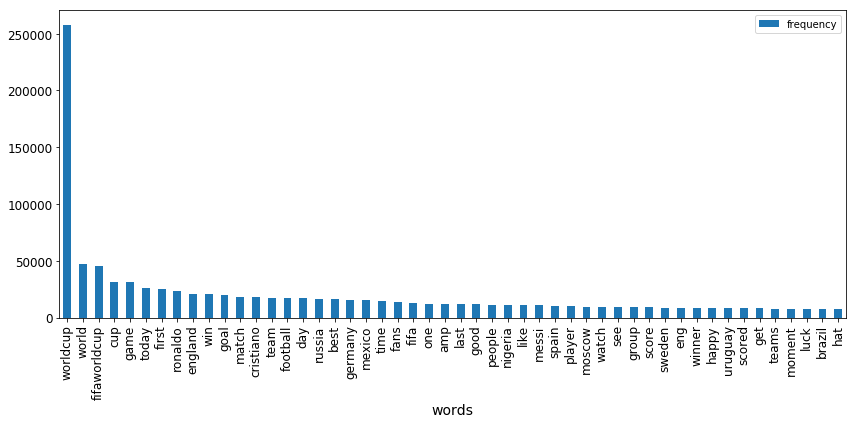

In [9]:
df[0:50].plot(kind='bar', x='words', figsize=(12,6))
save_fig("frequency_dist_words")

Saving figure wordcloud


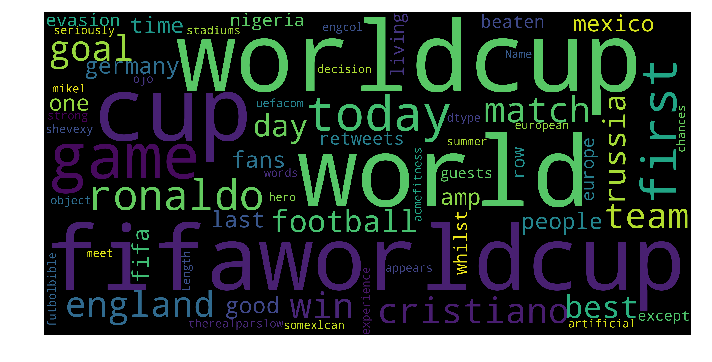

In [10]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words = 150,
        max_font_size=60, 
        collocations = False,
        scale=10,
        random_state=42 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    ax = plt.imshow(wordcloud)    
# ax = tweets_second.plot(kind="scatter", x="second", y="happiness_avg", figsize=(20,6))

    
show_wordcloud(df['words'][0:1000])
save_fig("wordcloud")
#show_wordcloud(Samsung_Reviews_positive['Reviews'])

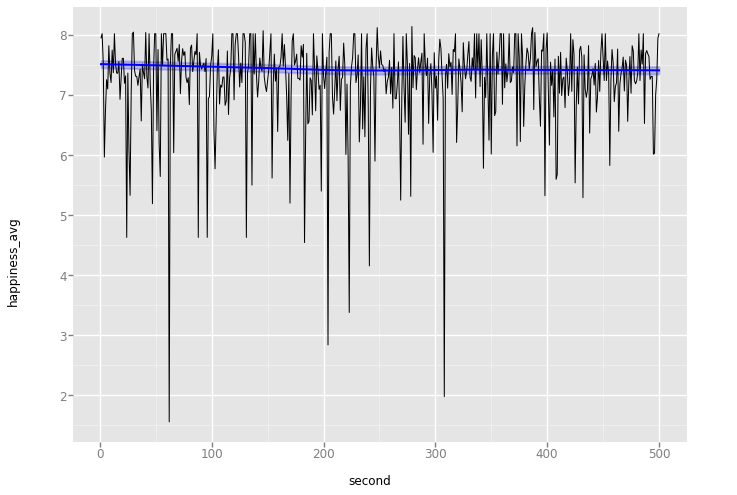

In [44]:
if __name__ == '__main__':
    extract_tar_file(tgz_name="preproccessed_tweets_date.tar.gz")
    tweets = spark.read.json('./datasets/tweets_happiness/tweets_happiness.json')
    tweets_happiness = tweets.withColumn('date' , regexp_replace('date', 't', ' '))
    tweets_happiness = tweets_happiness.withColumn('date' , regexp_replace('date', '\.', ' '))
    split_col = pyspark.sql.functions.split(tweets_happiness['date'], ' ')
    tweets_happiness = tweets_happiness.withColumn('time', split_col.getItem(1))
    tweets_happiness = tweets_happiness.withColumn('date', split_col.getItem(0))
    
    tweets_happiness = tweets_happiness.withColumn('hour_min',\
                                                   F.regexp_extract("time", pattern='(\d+):(\d+)', idx=0))
    tweets_happiness = tweets_happiness.withColumn('hour',\
                                                   F.regexp_extract("time", pattern='(\d+)', idx=0))
    tweets_happiness_min = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("hour_min")))).\
                        drop('happiness_score', 'words', 'time', 'hour_min', 'hour')
    tweets_happiness_hour = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("hour")))).\
                        drop('happiness_score', 'words', 'time', 'hour_min','hour')

    tweets_happiness_second = tweets_happiness.withColumn('date' , (concat(col("date"), lit(" "), col("time")))).\
                        drop('happiness_score', 'words', 'time', 'hour_min','hour')
    
    tweets_happiness_second = avg_happiness_over_date(tweets_happiness_second, 'date', 'happiness_avg')
    tweets_happiness_min = avg_happiness_over_date(tweets_happiness_min, 'date', 'happiness_avg')
    tweets_happiness_hour = avg_happiness_over_date(tweets_happiness_hour, 'date', 'happiness_avg')

    tweets_happiness_second = tweets_happiness_second.sort('date')
    tweets_happiness_min = tweets_happiness_min.sort('date')
    tweets_happiness_hour = tweets_happiness_hour.sort('date')
    
    tweets_happiness_second.createOrReplaceTempView('tweets_happiness_second')
    tweets_second = spark.sql('select row_number() over (order by "date") as second, *\
                              from tweets_happiness_second')

    tweets_happiness_min.createOrReplaceTempView('tweets_happiness_min')
    tweets_min = spark.sql('select row_number() over (order by "date") as minute, *\
                            from tweets_happiness_min')

    tweets_happiness_hour.createOrReplaceTempView('tweets_happiness_hour')
    tweets_hour = spark.sql('select row_number() over (order by "date") as hour, *\
                            from tweets_happiness_hour')
        
    tweets_second = tweets_second.toPandas()
    tweets_min = tweets_min.toPandas()
    tweets_hour = tweets_hour.toPandas()
    
        
    ax = tweets_second[0:500].plot(kind="line", x="second", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_sec")
    
    ax = tweets_second[38862:58293].plot(kind="scatter", x="second", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_sec2")
    
    ax = tweets_second[58293:77724].plot(kind="scatter", x="second", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_sec3")
    
    ax = tweets_min.plot(kind="line", x="minute", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_min")
    
    ax = tweets_hour.plot(kind="line", x="hour", y="happiness_avg", figsize=(20,6))
    save_fig("happiness_avg_per_hour")

    filename = os.path.join(IMAGES_STORE_PATH, 'happiness_avg_sec_with_smooth.png' )
    p = ggplot(aes(x='second', y='happiness_avg'), data=tweets_second[0:500])
    p+geom_line()+stat_smooth(color='blue', size = 2, method = 'loess')
    p.save(filename = filename)
    
    filename = os.path.join(IMAGES_STORE_PATH, 'happiness_avg_min_with_smooth.png' )
    p = ggplot(aes(x='second', y='happiness_avg'), data=tweets_min)
    p+geom_line()+stat_smooth(color='blue', size = 2, method = 'loess')
    p.save(filename = filename)
    
    filename = os.path.join(IMAGES_STORE_PATH, 'happiness_avg_hour_with_smooth.png' )
    p = ggplot(aes(x='hour', y='happiness_avg'), data=tweets_hour)
    p+geom_point()+geom_line() + stat_smooth(color='blue', size = 2, method = 'loess' )
    p.save(filename = filename)

In [12]:
from ipywidgets import interact, fixed

In [41]:
def plot(dataframe, a=0):
    p = ggplot(aes(x='second', y='happiness_avg'), data=dataframe[a:a+1000])
    p+geom_line(color = 'blue')+stat_smooth(color='black', size = 2, method = 'loess')
    return p

In [42]:
widgets.interact(plot, dataframe = fixed(tweets_second), a = (0,116586, 1000))

interactive(children=(IntSlider(value=0, description='a', max=116586, step=1000), Output()), _dom_classes=('wi…

<function __main__.plot(dataframe, a=0)>

In [20]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [39]:
filename = os.path.join(IMAGES_STORE_PATH, 'happiness_avg_sec_with_smooth.png' )

tweets_second.iplot(kind = "scatter", y='happiness_avg', yrange=(0,9), shape=(20,6), xTitle= "Time(s)",
                    yTitle= "Average Happiness", filename = filename, asImage = True, theme= "solar", colors='blue')